# Analyzing NYC high schools via SAT Scores, Ratings, and Affordability 


In [1]:
import matplotlib.pyplot as plt
import numpy
import os
import re
import pandas as pd
from mpl_toolkits.basemap import Basemap
try:
    from inspect import cleandoc as dedent
except ImportError:
    from matplotlib.cbook import dedent
data = {}

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv",
    "property.csv"
]


for f in data_files:
    d = pd.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

  

# Read in the surveys

In [2]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey



# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

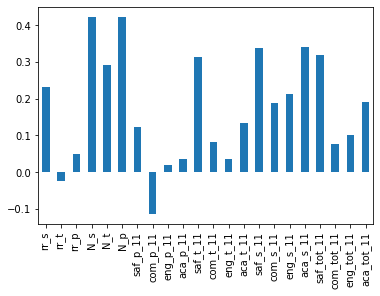

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

There is a strong correlation between sat_scores and several factors. There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

Another factor with high positive correlation is the saf_t_11 and saf_s_11 columns which feature teacher and student reported safety and respect. This is not a surprising outcome since one would expect school with higher academic standards and test scores to feature a safe environment for their students.

The aca_s_11 and aca_t_11 columns represent academic expectations reported by the students and teachers. This correlation is also not surprising considering schools with higher standards and expectations can be expected to result in higher standardized test scores. 

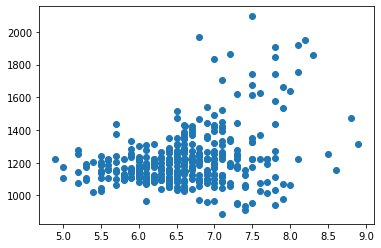

In [12]:
fig, ax=plt.subplots()

scatter=ax.scatter(combined["saf_s_11"],combined["sat_score"])
plt.show()

There is a weak positive correlation between safety and sat_scores. The correlation seems to be higher at the lower end of the spectrum for both categories. 

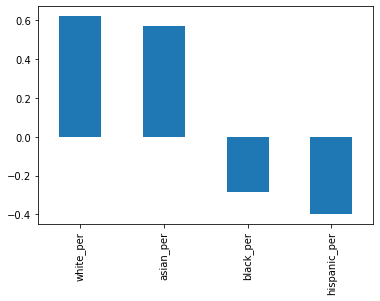

In [13]:
race_per = ["white_per","asian_per","black_per","hispanic_per"]

%matplotlib inline
combined.corr()["sat_score"][race_per].plot.bar()


With sat scores, there is a strong positive correlation between the percentage of white and asian students and a negative correlation with black and hispanic students. This is not a surprising outcome since stucks from black and hispanic families tend to come from poorer backgrounds and therefore are more likely to like in underperforming school districts. 

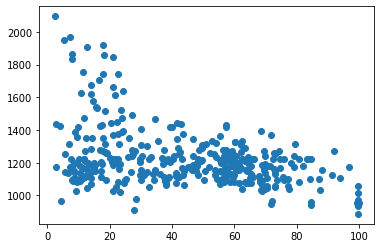

In [14]:
fig, ax=plt.subplots()
scatter = ax.scatter(combined["hispanic_per"], combined["sat_score"])
plt.show()

There is an evident negative correlation accorinding to the scatterplot with a few, and more specifically, one outlier on top with the highest score(s) belonging to the school with the lower percentage of hispanic students.

In [15]:
print(combined[combined["hispanic_per"] > 99]["SCHOOL NAME"])


44                         MANHATTAN BRIDGES HIGH SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The scores seems to host mostly recent immigrants to the US who may have limited language abilities which would explain the lower SAT scores. 

In [16]:
low_hisp=combined[combined["hispanic_per"] < 10]
low_h_high_s=low_hisp[low_hisp["sat_score"]>1800]

print(low_h_high_s["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools on this list feature rigourus academic standards and a few of them have an entrance examination as an admissions requirement which would weed out the students who were low performers or had weaker language abilities. 

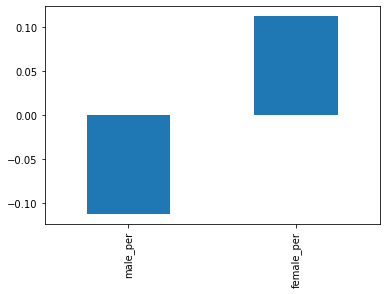

In [17]:
gender=["male_per","female_per"]

%matplotlib inline
combined.corr()["sat_score"][gender].plot.bar()

There is a negative correlation between the percentage of male test takes and a positive one between female test takes signifying that women, on average, score higher on the SAT. However, this is is a week correlation. 

In [18]:
high_female = combined[combined["female_per"]>80]["SCHOOL NAME"]
print(high_female)

15     URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...
49                 THE HIGH SCHOOL OF FASHION INDUSTRIES
70                       YOUNG WOMEN'S LEADERSHIP SCHOOL
71                       YOUNG WOMEN'S LEADERSHIP SCHOOL
104                        WOMEN'S ACADEMY OF EXCELLENCE
133                     HIGH SCHOOL FOR VIOLIN AND DANCE
137    THE MARIE CURIE SCHOOL FOR MEDICINE, NURSING, ...
191    URBAN ASSEMBLY INSTITUTE OF MATH AND SCIENCE F...
264       THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE
329              YOUNG WOMEN'S LEADERSHIP SCHOOL, QUEENS
338             YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA
Name: SCHOOL NAME, dtype: object


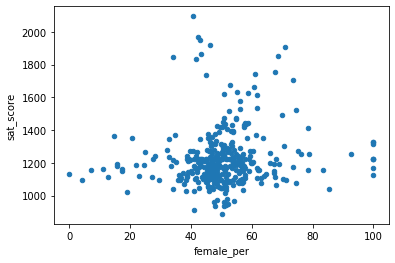

In [19]:
combined.plot.scatter("female_per", "sat_score")
plt.show()

This scatter plot confirms a weak correlation. 

In [20]:
high_female = combined[combined["female_per"]>60]
high_f_high_s=high_female[high_female["sat_score"]>1700]

print(high_f_high_s["SCHOOL NAME"])


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools seem to have rigorous standards and to be highly selective. 

In [21]:
combined["total_enrollment"].value_counts

<bound method IndexOpsMixin.value_counts of 0       422
1       394
2       598
3       367
4      1613
       ... 
358     606
359     434
360     398
361     263
362     462
Name: total_enrollment, Length: 363, dtype: int64>

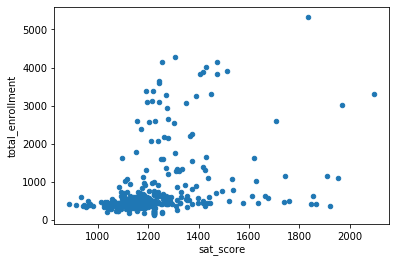

In [22]:
combined.plot.scatter("sat_score", "total_enrollment")


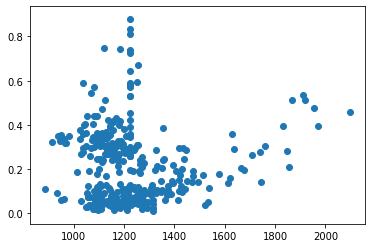

In [23]:
ap_per = combined["AP Test Takers "]/combined["total_enrollment"]
fig, ax=plt.subplots()
scatter = ax.scatter(combined["sat_score"], ap_per)
plt.show()

Although some correlation can be seen via the scatterplot, it is a very weak one. 

In [24]:
combined["school_dist"].value_counts()

02    48
10    22
09    20
11    15
14    14
17    14
07    13
24    13
13    13
19    12
12    12
03    12
28    11
21    11
08    11
18    11
06    10
27    10
31    10
30     9
15     9
25     8
29     8
05     7
04     7
01     6
32     6
20     5
26     5
16     4
22     4
23     3
Name: school_dist, dtype: int64

In [25]:
combined["AVERAGE CLASS SIZE"].value_counts()

23.020000    2
25.042857    2
25.257143    2
25.711765    2
21.356250    2
            ..
25.850000    1
20.975000    1
21.850000    1
23.921053    1
21.312500    1
Name: AVERAGE CLASS SIZE, Length: 354, dtype: int64

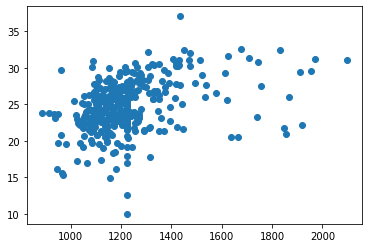

In [26]:
fig, ax=plt.subplots()
scatter = ax.scatter(combined["sat_score"], combined["AVERAGE CLASS SIZE"])
plt.show()

Although some correlation can be seen via the scatterplot as well, it is a very weak one. 

In [27]:
for col in combined:
    print(col)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

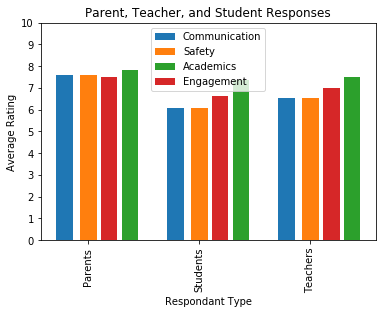

In [28]:
import matplotlib.pyplot as plt
from numpy import arange
import numpy as np
%matplotlib inline


saf_t_mean=combined["saf_t_11"].mean()
saf_s_mean=combined["saf_s_11"].mean()
saf_p_mean=combined["saf_p_11"].mean()

aca_t_mean=combined["aca_t_11"].mean()
aca_s_mean=combined["aca_s_11"].mean()
aca_p_mean=combined["aca_p_11"].mean()

com_t_mean=combined["com_t_11"].mean()
com_s_mean=combined["com_s_11"].mean()
com_p_mean=combined["com_p_11"].mean()

eng_t_mean=combined["eng_t_11"].mean()
eng_s_mean=combined["eng_s_11"].mean()
eng_p_mean=combined["eng_p_11"].mean()


comm_cols=[com_p_mean,com_s_mean,com_t_mean]
saf_cols=[com_p_mean,com_s_mean,com_t_mean]
aca_cols=[aca_p_mean,aca_s_mean,aca_t_mean]
eng_cols=[eng_p_mean,eng_s_mean,eng_t_mean]

col_names = ["Parents","Students","Teachers"]

total_cols = comm_cols,saf_cols,aca_cols
index = np.arange(len(total_cols))
score_label = np.arange(0,11,1)

bar_width=0.15

fig, ax = plt.subplots()
bar_comm = ax.bar(index - bar_width/0.7, comm_cols, bar_width, label = "Communication" )
bar_safety = ax.bar(index, saf_cols, bar_width, label = "Safety" )
bar_aca = ax.bar(index + bar_width/0.4, aca_cols, bar_width, label = "Academics" )
bar_eng= ax.bar(index + bar_width/0.8, eng_cols, bar_width, label = "Engagement" )

tick_positions = range(1,10)

ax.set_xticks(index)
ax.set_xticklabels(col_names, rotation=90)


ax.set_yticklabels(score_label)
ax.set_yticks(score_label)

ax.set_xlabel("Respondant Type")
ax.set_ylabel("Average Rating")
ax.set_title("Parent, Teacher, and Student Responses")

ax.legend()

plt.show()

Although some analysis can be gathered from this graph, it is important to note that in the future, one must pay more attention to what they are trying to compare. In this instance, we want to compare the different responses between students, parents, and teachers. It would then  be helpful to include each of the four categories on the x-axis with one column for each respondant group. 

The following will put together a series of graphs for easier comparison. 

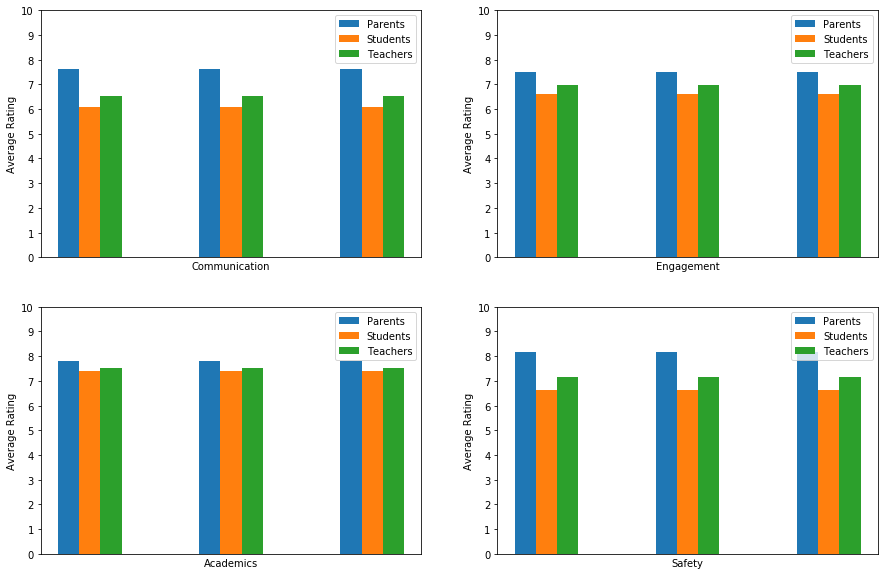

In [29]:

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

##First bar for communication 

bar_comm_p = ax1.bar(index - bar_width/1, com_p_mean, bar_width, label = "Parents" )
bar_comm_s = ax1.bar(index, com_s_mean, bar_width, label = "Students" )
bar_comm = ax1.bar(index + bar_width/1, com_t_mean, bar_width, label = "Teachers" )

ax.legend()
tick_positions = range(1,10)

ax1.set_xticks(index)

ax1.set_yticklabels(score_label)
ax1.set_yticks(score_label)

ax1.set_xlabel("Communication")
ax1.set_ylabel("Average Rating")

ax1.legend()

plt.gca().set_xticks([])
plt.xticks([])
ax1.set_xticks([])

##Second Graph for Engagement##
bar_aca_p = ax2.bar(index - bar_width/1, eng_p_mean, bar_width, label = "Parents" )
bar_aca_s = ax2.bar(index, eng_s_mean, bar_width, label = "Students" )
bar_aca_t = ax2.bar(index + bar_width/1, eng_t_mean, bar_width, label = "Teachers" )

ax2.legend()
tick_positions = range(1,10)

ax2.set_xticks(index)
ax2.set_xticklabels(col_names, rotation=90)


ax2.set_yticklabels(score_label)
ax2.set_yticks(score_label)

ax2.set_xlabel("Engagement")
ax2.set_ylabel("Average Rating")

ax2.legend()

plt.gca().set_xticks([])
plt.xticks([])
ax2.set_xticks([])

##Third Graph--> Academics 
bar_aca_p = ax3.bar(index - bar_width/1, aca_p_mean, bar_width, label = "Parents" )
bar_aca_s = ax3.bar(index, aca_s_mean, bar_width, label = "Students" )
bar_aca_t = ax3.bar(index + bar_width/1, aca_t_mean, bar_width, label = "Teachers" )

ax3.legend()
tick_positions = range(1,10)

ax3.set_xticks(index)
ax3.set_xticklabels(col_names, rotation=90)


ax3.set_yticklabels(score_label)
ax3.set_yticks(score_label)

ax3.set_xlabel("Academics")
ax3.set_ylabel("Average Rating")

ax3.legend()

plt.gca().set_xticks([])
plt.xticks([])
ax3.set_xticks([])


##Fourth Graph-->Safety 
bar_saf_p = ax4.bar(index - bar_width/1, saf_p_mean, bar_width, label = "Parents" )
bar_saf_s = ax4.bar(index, saf_s_mean, bar_width, label = "Students" )
bar_saf_t = ax4.bar(index + bar_width/1, saf_t_mean, bar_width, label = "Teachers" )

ax4.legend()
tick_positions = range(1,10)

ax4.set_xticks(index)
ax4.set_xticklabels(col_names, rotation=90)


ax4.set_yticklabels(score_label)
ax4.set_yticks(score_label)

ax4.set_xlabel("Safety")
ax4.set_ylabel("Average Rating")

ax4.legend()

plt.gca().set_xticks([])
plt.xticks([])
ax4.set_xticks([])


plt.show()








Now that there is a clearer visualization, it is easy to see that parents respond with higher scores for all the above categories while students respond with the lowest, and teachers scores range somewhere in between. Since they deal directly with institutions, often for longer periods of time, it may be reasonable to take look at teacher's score when assessing the overall performance of the school. 


It would not be interesting to figure out which neighborhoods have the best schools and to find the least expensive neighborhoods with the best schools.  

In [30]:
for i in combined:
    print(i)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

In [54]:
combined["postcode"].value_counts(dropna=False)
combined.shape

(363, 169)

In [32]:
prop = data["property"].copy()



In [33]:
prop.columns = prop.columns.str.lower()
prop["fullval"]=prop["fullval"].replace(0.0,np.nan)
prop["fullval"].value_counts(dropna=False )


NaN           15069
1000.0         1659
493000.0       1415
504000.0       1414
496000.0       1392
              ...  
60564.0           1
383130.0          1
383132.0          1
15504301.0        1
43037.0           1
Name: fullval, Length: 133813, dtype: int64

In [34]:
prop=prop.dropna(subset = ["postcode","fullval"], how="any")
prop["postcode"].value_counts()

10314.0    24996
11234.0    20023
10462.0    16899
10306.0    16747
11236.0    15745
           ...  
10118.0        1
10115.0        1
10110.0        1
10107.0        1
12345.0        1
Name: postcode, Length: 231, dtype: int64

In [35]:
prop["fullval"]=prop["fullval"].astype("int")
prop["postcode"]=prop["postcode"].astype("int")


In [36]:
gp=prop.groupby("postcode").agg(np.mean)
gp.reset_index(inplace=True) 

g_cols=["postcode","latitude","longitude", "fullval"]

gp=gp[g_cols]


In [37]:
combined=combined.merge(gp,how="left", on="postcode")

In [38]:
combined["postcode"].value_counts()

11101    12
10457    11
10002    11
10456    10
11201    10
         ..
10034     1
10033     1
10021     1
10009     1
10282     1
Name: postcode, Length: 116, dtype: int64

In [57]:
combined[["postcode","fullval"]]
combined[["fullval"]]=combined[["fullval"]].astype("int")
value_sorted=combined["fullval"].sort_values(ascending=False)


1490211    12
2608911    11
1265427    11
2396047    10
1096677    10
           ..
1319666     1
844712      1
936651      1
828105      1
1510404     1
Name: fullval, Length: 116, dtype: int64

In [87]:
low_mark = combined[combined["fullval"]<700000]
low_m_high_s=low_mark[low_mark["sat_score"]>1300]

print(low_m_high_s["postcode"].value_counts())

10301    2
10314    2
11433    1
11416    1
10469    1
10306    1
10312    1
Name: postcode, dtype: int64


According to the data available in the combined dataset, these zip codes belong to the schools with the highest SAT scores located in the cheapest districts according to market value of housing. These districts include Staten Island and Queens. 